# **Regresiones lineales y regresiones logísticas.**

# Regresión lineal vs. regresión logística: qué son y cuándo usarlas

En aprendizaje supervisado, una “regresión” es un modelo que relaciona una variable objetivo con un conjunto de variables explicativas (features). Dos de las regresiones más usadas son la **regresión lineal** y la **regresión logística**. Aunque comparten el nombre y la idea de modelar una relación entre variables, se aplican a objetivos diferentes y se entrenan con criterios distintos.

## Regresión lineal

La **regresión lineal** modela una variable objetivo **continua** (numérica) como una combinación lineal de las variables explicativas. En su forma más simple (una sola variable explicativa), busca aproximar la relación:

$$
y \approx \beta_0 + \beta_1 x
$$

y en el caso multivariable:

$$
y \approx \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p
$$

El entrenamiento se hace típicamente minimizando la suma de cuadrados de los residuos (errores) entre el valor real y el predicho, lo que lleva al enfoque de **mínimos cuadrados**.

### ¿Cuándo se usa?
Se usa cuando el resultado que queremos predecir es un valor real continuo, por ejemplo:
- Precio de una vivienda
- Temperatura, humedad o concentración de un contaminante
- Demanda de energía o consumo
- Tiempo de entrega, duración de un proceso

### ¿Qué tipo de casos explica bien?
- Relaciones aproximadamente lineales (o que pueden hacerse “casi lineales” con transformaciones).
- Situaciones donde interesa interpretar el efecto promedio de una variable sobre la respuesta (interpretabilidad de coeficientes).
- Escenarios donde un modelo base y estable es preferible antes de usar modelos más complejos.

## Regresión logística

La **regresión logística** se usa cuando la variable objetivo es **binaria** (dos clases), típicamente codificada como $y \in \{0,1\}$. En lugar de predecir directamente un valor real, la logística modela una **probabilidad**:

$$
p(x) = \Pr(y=1 \mid x)
$$

usando la función sigmoide:

$$
p(x) = \sigma(\beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p)
\quad \text{donde} \quad
\sigma(z)=\frac{1}{1+e^{-z}}
$$

Una forma útil de interpretarla es que modela el **log-odds** (logaritmo de las probabilidades relativas) como lineal en $x$:

$$
\log\left(\frac{p(x)}{1-p(x)}\right)=\beta_0+\beta_1 x_1+\cdots+\beta_p x_p
$$

El entrenamiento se realiza por **máxima verosimilitud** (equivalente a minimizar la pérdida de entropía cruzada o *cross-entropy*), no por mínimos cuadrados.

### ¿Cuándo se usa?
Se usa cuando queremos clasificar entre dos clases, por ejemplo:
- Aprobado / no aprobado
- Enfermo / sano
- Fraude / no fraude
- Cliente se va (churn) / cliente se queda
- Evento ocurre / no ocurre

### ¿Qué tipo de casos explica bien?
- Problemas de clasificación binaria donde se necesita una probabilidad interpretable.
- Situaciones en las que el costo de falsos positivos y falsos negativos es importante (porque se puede ajustar el umbral de decisión).
- Casos donde interesa interpretar efectos mediante *odds ratios* ($e^{\beta_j}$).

## Diferencia clave entre ambas

- **Regresión lineal**: predice un número real $ \hat{y} \in \mathbb{R} $ (variable continua).
- **Regresión logística**: predice una probabilidad $ \hat{p} \in (0,1) $ y luego clasifica usando un umbral (por ejemplo 0.5), para objetivos binarios.

## Regla práctica rápida para escoger

- Si tu objetivo es un **valor continuo** → empieza con **regresión lineal**.
- Si tu objetivo son **dos clases** (sí/no, 0/1) → usa **regresión logística**.
- En ambos casos, es buena práctica comparar contra un **baseline**, validar con un esquema correcto (train/test o cross-validation) y revisar supuestos y estabilidad antes de concluir.


# **Vamos a ello:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, confusion_matrix

# =========================================================
# 1) Regresión lineal: y = beta0 + beta1*x + ruido
# =========================================================
def make_linear_data(n=120, beta0=2.0, beta1=3.5, x_min=-2.0, x_max=2.0, noise_std=1.0, seed=42):
    rng = np.random.default_rng(seed)
    x = rng.uniform(x_min, x_max, size=n)
    eps = rng.normal(0.0, noise_std, size=n)
    y = beta0 + beta1 * x + eps
    X = x.reshape(-1, 1)
    return X, y

# =========================================================
# 2) Regresión logística: y ~ Bernoulli(sigmoid(beta0 + b1*x1 + b2*x2))
# =========================================================
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def make_logistic_data(n=300, beta0=-0.3, beta=(2.0, -1.2), x_std=1.0, seed=123):
    """
    Genera 2 features para poder graficar frontera de decisión.
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(0.0, x_std, size=(n, 2))
    z = beta0 + beta[0] * X[:, 0] + beta[1] * X[:, 1]
    p = sigmoid(z)
    y = rng.binomial(1, p, size=n)
    return X, y, p

In [2]:
# =========================================================
# A) Demo regresión lineal
# =========================================================
X_lin, y_lin = make_linear_data(
    n=120,
    beta0=2.0,
    beta1=3.5,
    x_min=-2.0,
    x_max=2.0,
    noise_std=1.0,
    seed=7
)
#np.ravel(X_lin)
pd.DataFrame({"X":np.ravel(X_lin),"Y":np.ravel(y_lin)})

,X,Y
0,0.500382,3.944082
1,1.588855,7.650300
2,1.102743,5.268571
3,-1.099171,-1.965709
4,-0.799335,-2.795418
...,...,...
115,1.011910,7.566846
116,1.242107,4.954587
117,-1.452944,-2.197401
118,-0.324385,0.775163


=== REGRESIÓN LINEAL ===
Coeficientes estimados: beta0=1.913, beta1=3.572
RMSE test: 0.853
R^2  test: 0.957


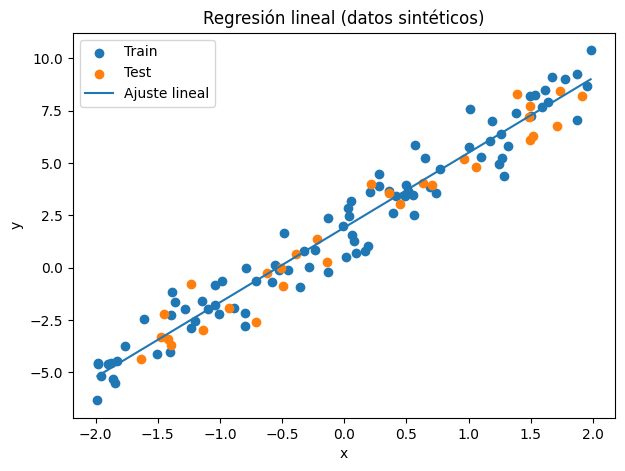

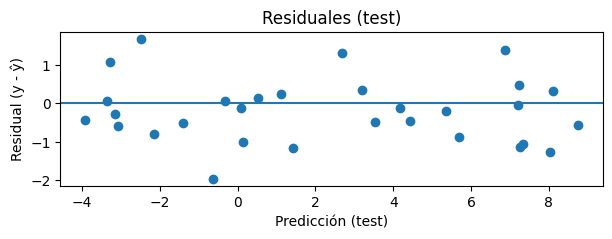

In [3]:
Xtr, Xte, ytr, yte = train_test_split(X_lin, y_lin, test_size=0.25, random_state=7)

lin_model = LinearRegression()
lin_model.fit(Xtr, ytr)

yhat_te = lin_model.predict(Xte)

print("=== REGRESIÓN LINEAL ===")
print(f"Coeficientes estimados: beta0={lin_model.intercept_:.3f}, beta1={lin_model.coef_[0]:.3f}")
print(f"RMSE test: {np.sqrt(mean_squared_error(yte, yhat_te)):.3f}")
print(f"R^2  test: {r2_score(yte, yhat_te):.3f}")

# Gráfica: puntos + recta ajustada
x_grid = np.linspace(X_lin.min(), X_lin.max(), 200).reshape(-1, 1)
y_grid = lin_model.predict(x_grid)

plt.figure(figsize=(7,5))
plt.scatter(Xtr[:, 0], ytr, label="Train")
plt.scatter(Xte[:, 0], yte, label="Test")
plt.plot(x_grid[:, 0], y_grid, label="Ajuste lineal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regresión lineal (datos sintéticos)")
plt.legend()
plt.show()

# Residuales
resid = yte - yhat_te
plt.figure(figsize=(7,2))
plt.scatter(yhat_te, resid)
plt.axhline(0.0)
plt.xlabel("Predicción (test)")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuales (test)")
plt.show()

In [4]:
# =========================================================
# B) Demo regresión logística (2D)
# =========================================================
X_log, y_log, p_true = make_logistic_data(
    n=350,
    beta0=-0.3,
    beta=(2.0, -1.2),
    x_std=1.0,
    seed=9
)

len(np.ravel(y_log)), len(np.ravel(X_log)), len(np.ravel(p_true))
pd.DataFrame({"X1":np.ravel(X_log[:,0]),"X2":np.ravel(X_log[:,1]),"Y":np.ravel(y_log),"True":np.ravel(p_true)})

,X1,X2,Y,True
0,-0.802837,0.242850,0,0.100012
1,-1.656345,0.656105,0,0.012128
2,1.143453,-0.452611,1,0.926221
3,0.430486,0.250933,0,0.564600
4,-0.394352,-0.862405,1,0.486549
...,...,...,...,...
345,0.692799,-1.460610,1,0.944712
346,-0.332201,0.824126,1,0.124188
347,0.539739,0.645382,0,0.501255
348,-0.572212,0.195433,0,0.157235



=== REGRESIÓN LOGÍSTICA ===
Accuracy test: 0.818
ROC-AUC  test: 0.916
Matriz de confusión (test):
[[41  6]
 [10 31]]


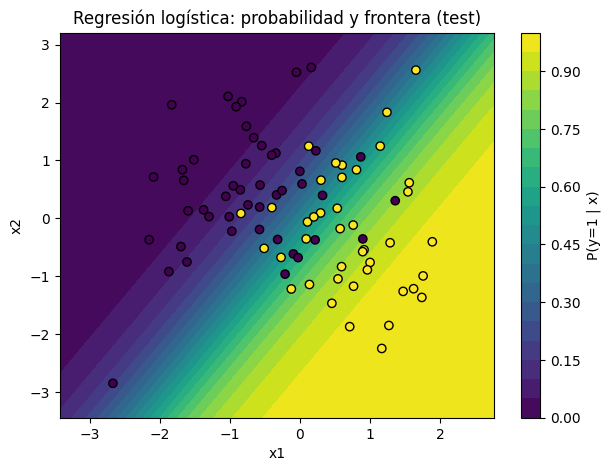

In [5]:
Xtr, Xte, ytr, yte = train_test_split(X_log, y_log, test_size=0.25, random_state=9, stratify=y_log)

# Pipeline típico: escalar + logística
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=2000))
])

log_model.fit(Xtr, ytr)

proba_te = log_model.predict_proba(Xte)[:, 1]
pred_te = (proba_te >= 0.5).astype(int)

print("\n=== REGRESIÓN LOGÍSTICA ===")
print(f"Accuracy test: {accuracy_score(yte, pred_te):.3f}")
print(f"ROC-AUC  test: {roc_auc_score(yte, proba_te):.3f}")
print("Matriz de confusión (test):")
print(confusion_matrix(yte, pred_te))

# Frontera de decisión (en el espacio original)
# Creamos malla sobre X1-X2 y evaluamos proba
x1_min, x1_max = X_log[:, 0].min() - 0.5, X_log[:, 0].max() + 0.5
x2_min, x2_max = X_log[:, 1].min() - 0.5, X_log[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250),
                       np.linspace(x2_min, x2_max, 250))
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_proba = log_model.predict_proba(grid)[:, 1].reshape(xx1.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx1, xx2, grid_proba, levels=20)
plt.colorbar(label="P(y=1 | x)")
plt.scatter(Xte[:, 0], Xte[:, 1], c=yte, edgecolor="k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Regresión logística: probabilidad y frontera (test)")
plt.show()

# **Usemos un paquete ya listo....**

## **Regresion Lineal...**
Usando un dataset conocido y famoso, ¿Cómo varía el peso del cerebro (cabeza) en función del tamaño que tiene...

In [6]:
import statsmodels.api as sm

In [7]:
# fitting the model
#Para los datos aqui usamos este dataset: https://media.geeksforgeeks.org/wp-content/cdn-uploads/20220522225116/headbrain11.csv
df1=pd.read_csv("https://media.geeksforgeeks.org/wp-content/cdn-uploads/20220522225116/headbrain11.csv")
df1

,Head Size(cm^3),Brain Weight(grams)
0,4512,1530
1,3738,1297
2,4261,1335
3,3777,1282
4,4177,1590
...,...,...
232,3214,1110
233,3394,1215
234,3233,1104
235,3352,1170


In [8]:
X,y=df1["Head Size(cm^3)"],df1["Brain Weight(grams)"]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.params

const              325.573421
Head Size(cm^3)      0.263429
dtype: float64

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Brain Weight(grams)   R-squared:                       0.639
Model:                             OLS   Adj. R-squared:                  0.638
Method:                  Least Squares   F-statistic:                     416.5
Date:                 Fri, 30 Jan 2026   Prob (F-statistic):           5.96e-54
Time:                         08:29:11   Log-Likelihood:                -1350.3
No. Observations:                  237   AIC:                             2705.
Df Residuals:                      235   BIC:                             2711.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             325.5734     47.141      6.906      0.000     232.701     418.446
Head Size(cm^3)     0.2634      0.013     20.409      0.000       0.238       0.289
==============================================================================
Omnibus:                        8.329   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.665
Skew:                           0.366   Prob(JB):                       0.0131
Kurtosis:                       3.584   Cond. No.                     3.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

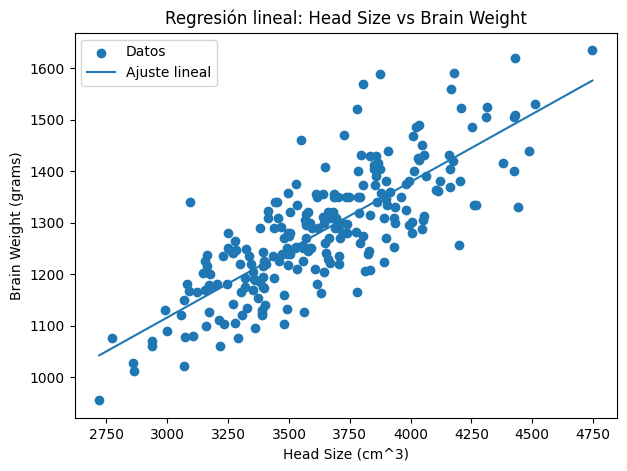

In [10]:
# Grid para la recta: debe tener const + x
x_grid = np.linspace(df1["Head Size(cm^3)"].min(),
                     df1["Head Size(cm^3)"].max(), 200)
X_grid = sm.add_constant(pd.DataFrame({"Head Size(cm^3)": x_grid}))

y_grid = results.predict(X_grid)

plt.figure(figsize=(7,5))
plt.scatter(df1["Head Size(cm^3)"], y, label="Datos")
plt.plot(x_grid, y_grid, label="Ajuste lineal")
plt.xlabel("Head Size (cm^3)")
plt.ylabel("Brain Weight (grams)")
plt.title("Regresión lineal: Head Size vs Brain Weight")
plt.legend()
plt.show()

## **Regresión logistica...**
Usando un dataset también: Predecimos si un estudiante será admitido en la universidad según su puntuación en el GMAT, su promedio general (GPA) y su experiencia laboral. La variable objetivo es binaria, es decir, admitido o no.

In [11]:
#Para los datos aqui usamos este dataset: https://media.geeksforgeeks.org/wp-content/uploads/20251025141423714536/logit_train1.csv
df = pd.read_csv('https://media.geeksforgeeks.org/wp-content/uploads/20251025141423714536/logit_train1.csv', index_col = 0)

#Define Dependent and Independent Variable
#Defining dependent and independent variables for training.
Xtrain = df[['gmat', 'gpa', 'work_experience']]
ytrain = df[['admitted']]

In [12]:
df

,gmat,gpa,work_experience,admitted
16,580,2.7,4,0
33,660,3.3,6,1
8,740,3.3,5,1
38,590,1.7,4,0
32,660,4.0,4,1
18,540,2.7,2,0
6,690,2.3,1,0
23,550,2.7,1,0
27,580,2.3,2,0
31,620,2.7,2,0


In [13]:
len(df)

30

In [14]:
Xtrain = df[['gmat', 'gpa', 'work_experience']][0:15]
ytrain = df[['admitted']][0:15]
Xtest = df[['gmat', 'gpa', 'work_experience']][15:]
ytest = df[['admitted']][15:]


log_reg = sm.Logit(ytrain, Xtrain).fit()
#Perform Predictions
#Performing predictions on testing data.
yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))

print('Actual values', list(ytest.values))
print('Predictions :', prediction)

Optimization terminated successfully.
         Current function value: 0.440047
         Iterations 7
Actual values [array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([0])]
Predictions : [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]


In [15]:
from sklearn.metrics import (confusion_matrix, accuracy_score)
cm = confusion_matrix(ytest, prediction) 
print ("Confusion Matrix : \n", cm) 
print('Test accuracy = ', accuracy_score(ytest, prediction)) 

Confusion Matrix : 
 [[6 0]
 [2 7]]
Test accuracy =  0.8666666666666667
